# <center>Redes Neuronales Convolucionales</center>
**<center>Martínez Casimiro Nestor Hugo</center>**

![](https://datagen.tech/wp-content/uploads/2023/04/Screenshot_3.png)

Las redes neuronales convolucionales son un tipo de arquitectura de redes neuronales profundas diseñadas especialmente para el procesamiento de datos que tienen una estructura de cuadrícula, como imágenes y datos en formato de cuadrícula.Son particularmente eficaces en la extracción y reconocimiento de patrones en datos de cuadrícula debido a su capacidad para aprender automáticamente características jerárquicas a diferentes escalas y niveles de abstracción, esto permitiendo que sean de carácter esencial en la visión artificial 

Estas tomaron su diseño de la biología, la teoría de grupos.
Y hablando más en apartado de cómo funcionan estas toman ventaja de las características vecinas están relacionadas entre sí.


## Problema con las MLP
![](https://www.researchgate.net/publication/330510477/figure/fig1/AS:717328085946368@1548035751724/The-differences-architecture-between-a-simple-MLP-and-a-CNN.ppm)

Este tipo de redes neuronales fue un gran paso a lo que las MLP representaban en inconvenientes, dado a que estas últimas procesan vectores unidimensionales, cosa que para el procesamiento de imágenes resultaba insatisfactorio, representaba una pérdida de información, además de que la cantidades de parámetros resultaban ser de cantidades extremadamente grandes, cosa que en términos computacionales se traduce a una baja eficiencia.

Adicionalmente este tipo de arquitectura de redes neuronales resultó no sólo ser útil para poder procesar imágenes, ya que también resultan ser competentes para trabajar con estructuras  secuenciales de una dimensión, como audio, texto o análisis de series de tiempo, cosas donde las redes neuronales recurrentes son utilizadas.


## <center>Partes en Estructura</center>

Las imágenes tienen una estructura que puede ser explotada por la naturaleza de una buena manera, y similarmente lo pueden hacer las CNN.
Por ejemplo, detectar un objeto en una imagen. Parece razonable que, sea cual sea el método que utilicemos para reconocer objetos, no nos preocupemos demasiado por la ubicación exacta del objeto en la imagen. Lo ideal sería que nuestro sistema aprovechará este conocimiento.
Un enfoque sería establecer secciones en una imagen y asignar probabilidades de que un objeto se encuentre ahí, las CNN sistematizan esta idea de invariancia espacial, explotándola para aprender representaciones útiles con menos parámetros.

Ahora podemos concretar estas intuiciones enumerando algunos desiderata para guiar nuestro diseño de una arquitectura de red neuronal adecuada para la visión por ordenador:


### Invariancia de traslación
En las primeras capaz, la red neuronal responde similarmete a la misma seccion con determinadas caractersiticas, independiemintemete de donde aparezca, este principio se llama invariancia de traslación.

El objetivo de invarianza se obtiene analizando la imgaen de entrada de la siguiente forma:

$$ [H]_{i,j}  = u +\sum_a \sum_b [V]_{a,b} [X]_{i+a,j+b} $$

A esto se le conoce una convolución

Donde:
* **X**: es la imagen de entrada
* **H**: una capa oculta
* **V**: un vector de pesos
* **u**: el sesgo

### Localidad
Las primeras capas de la red deben centrarse en las regiones locales, sin tener en cuenta el contenido de la imagen en las regiones distantes. Este es el principio de localidad. Con el tiempo, estas representaciones locales pueden agregarse para hacer predicciones a nivel de toda la imagen.

$$ [H]_{i,j}  = u +\sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} [V]_{a,b} [X]_{i+a,j+b} $$

Y esto forma lo que se llama una capa convolucional. Una CNN esta compuesta por una familia de redes neuronales que tienen capas convolucionales. 

### Canales
Pero dado a que las imagenes no son representadas solamente de manera bidimencional si no que tienen colores RGB, entonces tenemos la representación usando tensores de tercer orden:

$$ [H]_{i,j,d}  = u +\sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \sum_c  [V]_{a,b,c,d} [X]_{i+a,j+b,c} $$

En otras palabras, en lugar de tener una única representación oculta correspondiente a cada ubicación espacial, queremos un vector completo de representaciones ocultas correspondientes a cada ubicación espacial. Podríamos pensar que las representaciones ocultas comprenden una serie de cuadrículas bidimensionales apiladas unas sobre otras. Como en las entradas, a veces se denominan canales. También se denominan a veces mapas de características, ya que cada uno proporciona un conjunto espacializado de características aprendidas para la capa siguiente. Intuitivamente, se podría imaginar que en las capas inferiores que están más cerca de las entradas, algunos canales podrían especializarse para reconocer bordes mientras que otros podrían reconocer texturas.

## <center>Convolución para Imagenes</center>

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

Usando como ejemplo una matriz de información 3x3, con un kernel 2x2 podemos ver como de nuestra entrada sale $H$ (El cuadro 2x2 de los datos tiene las dimensiones dadas por el kernel y se llama ventana de convolusión)
![](https://d2l.ai/_images/correlation.svg)
Y esto no es más que una operacion de correlación cruzda

In [2]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(
                X[i: i + h, j: j + w] * K))
    return Y

X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = tf.constant([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[19., 25.],
       [37., 43.]], dtype=float32)>

## <center>Padding y Stride</center>

Un problema delicado al aplicar capas convolucionales es que tendemos a perder píxeles en el perímetro de nuestra imagen en función del tamaño del kernel de convolución y por tanto también perdemos infromación, además el kernel, también determina el tamaño de salida de la capa covolusional y en ultima instancia, influir en la arquitectura y rendimiento de la red.

Para abarcar estas situaciones existen enfoques que permiten ayudar.

### Padding
Dado que normalmente utilizamos kernels pequeños, es posible que en una convolución determinada sólo perdamos unos pocos píxeles, pero esto puede aumentar a medida que aplicamos muchas capas convolucionales sucesivas. Una solución directa a este problema es añadir píxeles adicionales de relleno alrededor del límite de nuestra imagen de entrada, aumentando así el tamaño efectivo de la imagen. Normalmente, los valores de los píxeles adicionales se fijan en cero.
![](https://d2l.ai/_images/conv-pad.svg)

### Stride
 El paso es el número de píxeles en los que se desplaza el filtro (kernel) durante la operación de convolución. Un valor de paso mayor reduce la resolución espacial de la salida, ya que el filtro se desplaza más rápidamente. Un valor de paso menor proporciona una salida con mayor resolución espacial.


## <center>Entradas y salidas multiples</center>

Cuando añadimos canales a la mezcla, nuestras representaciones de entrada y ocultas se convierten en tensores tridimensionales. Por ejemplo, cada imagen de entrada RGB tiene forma  $3 \cdot h \cdot w$.

### Cales de entrada multiples
Cuando los datos de entrada contienen múltiples canales, necesitamos construir un kernel de convolución con el mismo número de canales de entrada que los datos de entrada, para que pueda realizar la correlación cruzada con los datos de entrada.
Suponiendo que el número de canales de los datos de entrada sea $c_i$ el número de canales de entrada del kernel de convolución también debe ser $c_i$.  

Dado que la entrada y el kernel de convolución tienen cada uno $c_i$ canales, podemos realizar una operación de correlación cruzada en el tensor bidimensional de la entrada y el tensor bidimensional del núcleo de convolución para cada canal, sumando los $c_i$ (sumando los canales) para obtener un tensor bidimensional.

![](https://d2l.ai/_images/conv-multi-in.svg)

In [3]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return tf.reduce_sum([d2l.corr2d(x, k) for x, k in zip(X, K)], axis=0)
X = tf.constant([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = tf.constant([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 56.,  72.],
       [104., 120.]], dtype=float32)>

### Salidas con multiples canales

Independientemente del número de canales de entrada, hasta ahora siempre acabábamos con un canal de salida. Sin embargo, resulta esencial tener varios canales en cada capa. En las arquitecturas de redes neuronales más populares, en realidad aumentamos la dimensión de canales a medida que profundizamos en la red neuronal, normalmente reduciendo el muestreo para compensar la resolución espacial por una mayor profundidad del canal.  

Los canales están optimizados para ser útiles conjuntamente. Esto significa que, en lugar de asignar un único canal a un detector de bordes, puede significar simplemente que alguna dirección en el espacio de canales corresponde a la detección de bordes.

Para obtener unasalida con canales multiples, podemos crear un kernel tensor con forma $c_i \times w \times h$

To get an output with multiple channels, we can create a kernel tensor of shape 
 for every output channel.

In [4]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return tf.stack([corr2d_multi_in(X, k) for k in K], 0)
K = tf.stack((K, K + 1, K + 2), 0)
corr2d_multi_in_out(X, K)

<tf.Tensor: shape=(3, 2, 2), dtype=float32, numpy=
array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]], dtype=float32)>

## <center>Pooling</center>

En muchos casos, nuestra tarea final plantea alguna pregunta global sobre la imagen, por ejemplo, ¿contiene un gato? Por consiguiente, las unidades de nuestra capa final deben ser sensibles a toda la información de entrada. Al agregar gradualmente la información, obteniendo mapas cada vez más gruesos, logramos este objetivo de aprender en última instancia una representación global, al tiempo que mantenemos todas las ventajas de las capas convolucionales en las capas intermedias de procesamiento. Cuanto más profundizamos en la red, mayor es el campo receptivo (en relación con la entrada) al que es sensible cada nodo oculto. Reducir la resolución espacial acelera este proceso, ya que los núcleos de convolución cubren un área efectiva mayor.

En general, las capas de agrupamiento desempeñan un papel crucial en la eficacia de las CNN para captar características jerárquicas e invariantes de traslación en las imágenes, lo que resulta esencial para diversas tareas de visión por ordenador como el reconocimiento de objetos, la clasificación de imágenes y la detección. Ayudan a reducir la dimensionalidad de los datos, hacen que la red sea más robusta ante pequeños cambios espaciales y contribuyen a la capacidad de la red para generalizar bien ante nuevos datos.

### Maximum Pooling and Average Pooling

Al igual que las capas convolucionales, los operadores de pooling consisten en una ventana de forma fija que se desliza por todas las regiones de la entrada de acuerdo con su paso, calculando una única salida para cada ubicación atravesada por la ventana de forma fija. Sin embargo, a diferencia del cálculo de correlación cruzada de las entradas y los núcleos en la capa convolucional, la capa de pooling no contiene parámetros (no hay kernel). En su lugar, los operadores de pooling son deterministas y suelen calcular el valor máximo o el valor medio de los elementos de la ventana de pooling. Estas operaciones se denominan pooling máximo  y pooling medio, respectivamente.

En casi todos los casos, max pooling es preferible a la avergage pooling.

En ambos casos, al igual que con el operador de correlación cruzada, podemos pensar que la ventana de agrupación comienza en la parte superior izquierda del tensor de entrada y se desliza por él de izquierda a derecha y de arriba abajo. En cada punto de la ventana de agrupación, se calcula el valor máximo o medio del subtensor de entrada en la ventana, dependiendo de si se utiliza la agrupación máxima o media.

![](https://d2l.ai/_images/pooling.svg)

In [5]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = tf.Variable(tf.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w +1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j].assign(tf.reduce_max(X[i: i + p_h, j: j + p_w]))
            elif mode =='avg':
                Y[i, j].assign(tf.reduce_mean(X[i: i + p_h, j: j + p_w]))
    return Y

In [6]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[4., 5.],
       [7., 8.]], dtype=float32)>

In [7]:
pool2d(X, (2, 2), 'avg')

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

Al igual que las capas convolucionales, las capas de agrupamiento cambian la forma de la salida. Y como antes, podemos ajustar la operación para conseguir la forma de salida deseada rellenando la entrada y ajustando el paso.  

Al procesar datos de entrada multicanal, la capa de agrupación agrupa cada canal de entrada por separado, en lugar de sumar las entradas de los canales como en una capa convolucional. Esto significa que el número de canales de salida de la capa de agrupación es el mismo que el número de canales de entrada.

## <center>Red Neuronal Convolucional LeNet</center>

LeNet, una de las primeras CNN publicadas que captó una amplia atención por su rendimiento en tareas de visión por ordenador. El modelo fue introducido por Yann LeCun, entonces investigador de AT&T Bell Labs, con el fin de reconocer dígitos escritos a mano en imágenes.

Este trabajo representó la culminación de una década de investigación desarrollando la tecnología; en aquel momento, LeNet obtuvo resultados extraordinarios que igualaban el rendimiento de las máquinas de vectores de soporte, por entonces un enfoque dominante en el aprendizaje supervisado, logrando una tasa de error inferior al 1% por dígito. Con el tiempo, LeNet se adaptó al reconocimiento de dígitos para procesar depósitos en cajeros automáticos. A día de hoy, algunos cajeros automáticos siguen utilizando el código que Yann LeCun y su colega Leon Bottou escribieron en los años 90.

A alto nivel, LeNet  consta de dos partes: (i) un codificador convolucional formado por dos capas convolucionales; y (ii) un bloque denso formado por tres capas totalmente conectadas. La arquitectura se resume en
![](https://d2l.ai/_images/lenet.svg)

In [8]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5,
                                   activation='sigmoid', padding='same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                                   activation='sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(num_classes)])

In [9]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = tf.random.normal(X_shape)
    for layer in self.net.layers:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 28, 28, 1))

Conv2D output shape:	 (1, 28, 28, 6)
AveragePooling2D output shape:	 (1, 14, 14, 6)
Conv2D output shape:	 (1, 10, 10, 16)
AveragePooling2D output shape:	 (1, 5, 5, 16)
Flatten output shape:	 (1, 400)
Dense output shape:	 (1, 120)
Dense output shape:	 (1, 84)
Dense output shape:	 (1, 10)


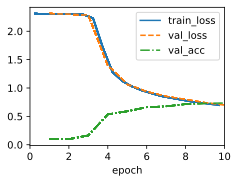

In [10]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128)
with d2l.try_gpu():
    model = LeNet(lr=0.1)
    trainer.fit(model, data)

![](https://d2l.ai/_images/output_lenet_4a2e9e_72_0.svg)

In [13]:
model.save("C:/Users/sangr/Documents/ModelosEntrenados/lenet_model")

INFO:tensorflow:Assets written to: C:/Users/sangr/Documents/ModelosEntrenados/lenet_model\assets


INFO:tensorflow:Assets written to: C:/Users/sangr/Documents/ModelosEntrenados/lenet_model\assets
